## Self-Consistency Loop
    X. Implement the self-consistency loop and iterate enough times to converge and plot the density

In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.integrate import simps

In [2]:
def D(x, N=100):
    '''
    Returns the operator form of first-derivative

            Parameters:
                    x (array): grid of 1D array
                    N (int): number of points on the grid

            Returns:
                    D (array): first-derivative operator
    '''
    h = x[1] - x[0]
    k = [np.ones(N-1), -np.ones(N-1)]
    offset = [1, -1]
    D = diags(k, offset).toarray()
    D = D/(2 * h)
    # # Boundary values where it is not well defined
    D[0, 0] = 0
    D[0, 1] = 0
    D[1, 0] = 0
    D[N-1, N-2] = 0
    D[N-2, N-1] = 0
    D[N-1, N-1] = 0
    return D


def D2(x, N=100):
    '''
    Returns the operator form of second-derivative

            Parameters:
                    x (array): grid of 1D array
                    N (int): number of points on the grid

            Returns:
                    D (array): first-derivative operator
    '''
    h = x[1] - x[0]
    k1 = [np.ones(N-1), -2*np.ones(N), np.ones(N-1)]
    offset = [-1, 0, 1]
    D2 = diags(k1, offset).toarray()
    D2 = D2/(h ** 2)
    # Boundary values where it is not well defined
    D2[0, 0] = 0
    D2[0, 1] = 0
    D2[1, 0] = 0
    D2[N-1, N-2] = 0
    D2[N-2, N-1] = 0
    D2[N-1, N-1] = 0
    return D2


def normalise_psi(psi, x):
    '''
    Normalises the given wavefunction

            Parameters:
                    psi (array): wavefunction psi
                    x (array): 1D grid of array

            Returns:
                    normalised psi
    '''
    int_psi_square = simps(abs(psi) ** 2, x)
    return psi/np.sqrt(int_psi_square)


def get_occupation_num(nElectron, maxElectron=2):
    '''
    Returns a list of occupation numbers for a given number of electrons

            Parameters:
                    nElectron (int): number of electrons
                    maxElectron (int): max number of allowed elecrons in one state

            Returns:
                    fn (array): occupation number
    '''
    nFloor = np.floor_divide(nElectron, 2)
    fn = maxElectron * np.ones(nFloor)
    if nElectron % 2:
        fn = np.append(fn, 1)
    return fn


def get_density(nElectron, psi, x):
    '''
    Returns electron density for a given number of electrona and wavefunction

            Parameters:
                    nElectron (int): number of electrons
                    psi (array): wavefunction
                    x (array): 1D grid of array

            Returns:
                    eDensity (array): electron density
    '''
    psiNorm = normalise_psi(psi, x)  # Normalisation
    fn = get_occupation_num(nElectron)
    eDensity = np.zeros(N)
    for f_n, psi in zip(fn, psiNorm.T):
        eDensity += f_n * (psi ** 2)
    return eDensity


def integrate(x, y):
    '''
    Returns the integration by simpson's method

            Parameters:
                    x (array): 1D grid of arra
                    y (array): integrand

            Returns:
                    result (float): result of the integration
    '''
    result = simps(y, x)
    return result


def calculate_exchange(eDensity, x):
    '''
    Returns exchange energy and potential for a given electron density

            Parameters:
                    eDensity (array): electron density
                    x (array): 1D grid of array

            Returns:
                    energy (float): exchange energy
                    potential (float): exchange potential
    '''
    energy = -3/4 * (3/np.pi) ** (1/3) * integrate(x, eDensity ** (4/3))
    potential = -(3/np.pi) ** (1/3) * eDensity ** (1/3)
    return energy, potential


def calculate_coulomb(eDensity, x, eps=0.1):
    '''
    Returns Coulomb/Hartree energy and potential for a given electron density

            Parameters:
                    eDensity (array): electron density
                    x (array): 1D grid of array

            Returns:
                    energy (float): Hartee energy
                    potential (float): Hartree potential
    '''
    h = x[1] - x[0]
    nx = eDensity[np.newaxis, :]
    nxp = eDensity[:, np.newaxis]
    w = x[np.newaxis, :]
    wp = x[:, np.newaxis]
    energy = 0.5 * np.sum(nx * nxp * h ** 2/np.sqrt((w - wp) ** 2 + eps))
    potential = np.sum((nx * h)/np.sqrt((w - wp) ** 2 + eps), axis=-1)
    return energy, potential

In [3]:
L = 5
N = 200
x = np.linspace(-L, L, N)
X = np.diagflat(x*x)
H = -D2(x, N)/2 + X
E, V = np.linalg.eigh(H)
psi = V
nElectron = 6

In [4]:
eDensity = np.zeros(N)
tol = 1e-5
converged = False
eOld = -np.Inf
count = 1
gsList = [-np.inf]
eDiffList = []
count = 1
while converged is False:
    T = -D2(x, N)/2
    X = x * x
    Ec, Vc = calculate_coulomb(eDensity, x)
    Ex, Vx = calculate_exchange(eDensity, x)
    H = T + np.diagflat(Vx + Vc + X)
    energy, psi = np.linalg.eigh(H)
    eDiff = energy[0] - gsList[-1]
    gsList.append(energy[0])
    # check convergence
    if abs(eDiff) < tol:
        print("converged!")
        convDensity = eDensity
        break
    # update density
    eDensity = get_density(nElectron, psi, x)
    print(f"Step : {count}  Energy : {energy[0]:<10.4f}  Energy Diff : {eDiff:.8f}")
    count += 1

else:
    print("Not converged")

Step : 1  Energy : 0.7069      Energy Diff : inf
Step : 2  Energy : 7.4812      Energy Diff : 6.77420515
Step : 3  Energy : 6.3788      Energy Diff : -1.10236741
Step : 4  Energy : 7.1502      Energy Diff : 0.77144608
Step : 5  Energy : 6.6330      Energy Diff : -0.51718552
Step : 6  Energy : 6.9992      Energy Diff : 0.36612189
Step : 7  Energy : 6.7476      Energy Diff : -0.25157045
Step : 8  Energy : 6.9247      Energy Diff : 0.17707861
Step : 9  Energy : 6.8019      Energy Diff : -0.12279888
Step : 10  Energy : 6.8880      Energy Diff : 0.08612108
Step : 11  Energy : 6.8280      Energy Diff : -0.05995217
Step : 12  Energy : 6.8700      Energy Diff : 0.04196024
Step : 13  Energy : 6.8407      Energy Diff : -0.02926063
Step : 14  Energy : 6.8612      Energy Diff : 0.02045783
Step : 15  Energy : 6.8469      Energy Diff : -0.01427765
Step : 16  Energy : 6.8569      Energy Diff : 0.00997707
Step : 17  Energy : 6.8499      Energy Diff : -0.00696576
Step : 18  Energy : 6.8548      Energy 

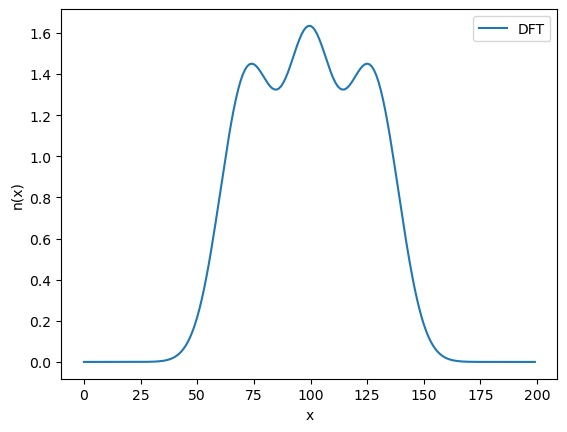

In [5]:
plt.plot(convDensity, label="DFT")
plt.xlabel("x")
plt.ylabel("n(x)")
plt.legend()
plt.show()